# Parallel KMeans implementation
Based on J. Y. Q. H. Z. W. a. J. C. Bowen Wang, “Parallelizing K-means-based Clustering on Spark,” International Conference on Advanced Cloud and Big Data, 2016. 

## Parallel partition based algorithm outline
1. Initialize centroids by randomly selecting k points from the data set. Broadcast selected centroids to all nodes
1. While centrodis still changing:
    1. For each partition do locally:
        1. For each point in partition:
            1. Compute distance to all centroids
            1. Asign closest cluster
        1. For each cluster in partition:
            1. Compute local mean
    1. Compute mean for each cluster for each partition


## Adaptations made to sugested implementation of the algorithm:
1. The authors suggest using SparseVector, with chosen data sets it is better to use regular arrys
1. We use random sample for centroids initialization as described in *Scalable K-Means++* because quality of inital centrods has a major effect on quality
1. We use crisp clustring only i. e. each point can be a member of one cluster only

In [1]:
import random 
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pyspark import SparkConf
from pyspark.mllib.clustering import KMeans, KMeansModel

conf = SparkConf().set("spark.python.profile", "true")


# For reproducability of results
RANDOM_SEED = 301191


%matplotlib inline

### Import and parse data set

In [2]:
data = sc.textFile("a3.txt")
parsed_data = data.map(lambda line: array([float(x) for x in line.strip().split()]))

parsed_data.take(5)

[array([53920., 42968.]),
 array([52019., 42206.]),
 array([52570., 42476.]),
 array([54220., 42081.]),
 array([54268., 43420.])]

In [3]:
# Store centroids in shared variable, this way all the centroids available localy for each slave
centroids_init = sc.broadcast(parsed_data.takeSample(False, 50, seed=RANDOM_SEED))

In [4]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1-v2)
    
def closest_centroid(point, centroids):
    # for dense data, we use euclidean distance
    centroid_dist_pairs = map(lambda centroid: (centroid, euclidean_dist(point, centroid)), centroids)
    return min(centroid_dist_pairs, key=lambda centroid_dist: centroid_dist[1])

def calc_partition_centroid_means(partition, centroids):
    distances = map(lambda point: 
            (point, 
             *closest_centroid(point, centroids)), 
        partition)
    
    distances = tuple(distances)
    df = pd.DataFrame(distances, columns=['Point', 'Centroid', 'Distance'])
    df['Centroid'] = tuple(df['Centroid'])

    return df.groupby('Centroid')['Point'].apply(np.mean).items()

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids.value))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = euclidean_dist(old_and_new_centroids[:,0], old_and_new_centroids[:,1])
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 0
    error = True
    while error > stop_distance and iteration < max_iterations:
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0} - Distance between old and new centroid: {1}".format(iteration, error))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()
    
    
final_centroids = pkmeans(parsed_data, 50)

0 Distance between old and new centroid: 17177.057969338788
1 Distance between old and new centroid: 10533.184273412005
2 Distance between old and new centroid: 8960.050172929392
3 Distance between old and new centroid: 5625.252803898692
4 Distance between old and new centroid: 2716.560894585595
5 Distance between old and new centroid: 1167.525546186056
6 Distance between old and new centroid: 652.24702923321
7 Distance between old and new centroid: 426.8672377514564
8 Distance between old and new centroid: 475.13477233915404
9 Distance between old and new centroid: 436.403620550595
10 Distance between old and new centroid: 332.55005911630593
11 Distance between old and new centroid: 266.58285005256874
12 Distance between old and new centroid: 269.68177879901197
13 Distance between old and new centroid: 224.88192576257066
14 Distance between old and new centroid: 102.35551924555494
15 Distance between old and new centroid: 112.50888828793704
16 Distance between old and new centroid: 75

In [25]:
clusters = KMeans.train(parsed_data, 50, maxIterations=150, initializationMode="random")

## Syntetic claster plot
* The first test if the algorith is a syntetic data test
* Blue sqares represent the data.
* Read dots are centers of clusters compueted by our implementation
* Yellow dots are the centerts of cluster computed by spark mllib algorithm

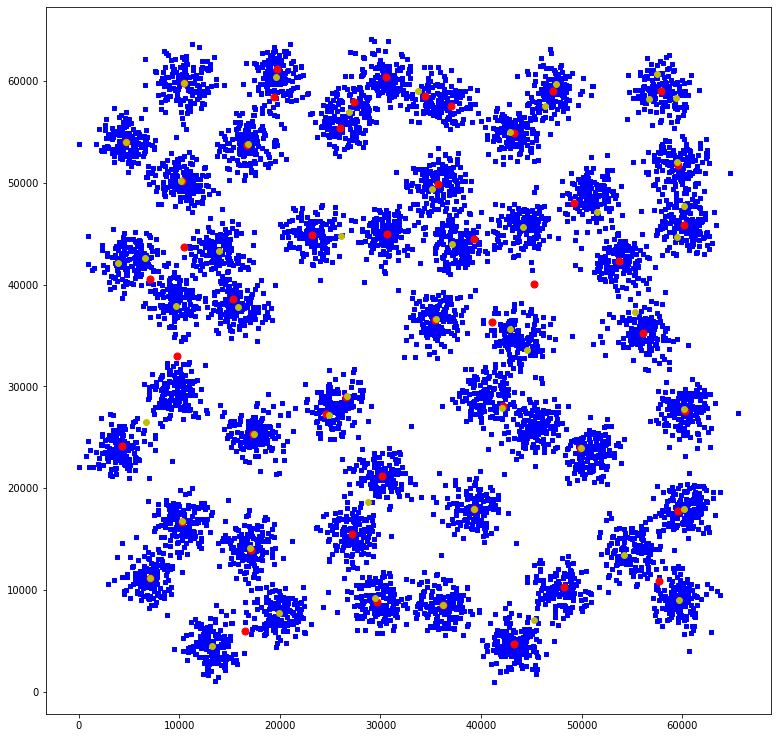

In [26]:
xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(final_centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


x1, y1 = zip(*clusters.centers)

ax1.scatter(xdata, ydata, s=10, color='b', marker="s")
ax1.scatter(x, y, s=50, color='r', marker="o")
ax1.scatter(x1, y1, s=35, color='y', marker="o")